# Linear Regression with Momentum Batch Gradient Descent

This notebook demonstrates how to perform linear regression using **momentum batch gradient descent** on synthetic data. We'll walk through each part of the code step-by-step to understand the concepts involved.

#### **Import Required Libraries**

- **NumPy** is used for numerical operations and handling arrays.
- **Matplotlib** is for plotting graphs to visualize results.
- **TQDM** provides a progress bar for loops.
- **Scikit-learn** is used for calculating the R² score, which evaluates our model.


In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

pbar_format = "{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]"

## 1. Helper Function for all GD

### Generate Synthetic Data

We create a function to generate synthetic data that follows a linear relationship.
- **Parameters**:
  - `n`: Number of data points.
  - `bias`: Intercept of the line.
  - `weight`: Slope of the line.
- **Output**: An array containing features and labels.

In [2]:
def synthetic_data(n=100, bias=5, weight=2):
    
    np.random.seed(42)
    torch.manual_seed(42) 
    # Generate synthetic data (linear relationship with some noise)
    bias = 5
    weight = 2
    noise = np.random.randn(n)

    features = np.random.rand(n, 1) * 10
    labels = bias + weight * features.flatten() + noise  # Linear relation with noise

    data = np.hstack((features, labels.reshape(-1, 1)))
    return data

### Visualizing Results

This function will create plots for:
- Loss over epochs
- Values of model parameters (weights)


In [3]:
def plot_results(history, cost_history, lr, fontsize=10, markersize=8):

    history = np.array(history)

    # Create subplots: 3 rows, 1 column
    fig, axs = plt.subplots(history.shape[1] + 1, 1, figsize=(12, 15))  # Adjusted number of rows

    # Plot the loss over epochs
    axs[0].plot(range(len(cost_history)), cost_history, '*-b', markersize=markersize, label='Loss per Epoch')
    axs[0].set_title(f'Loss per Epoch for lr={lr}', fontsize=16, fontweight='bold')
    axs[0].set_xlabel('Iteration', fontsize=fontsize)
    axs[0].set_ylabel('Loss', fontsize=fontsize)
    axs[0].legend()
    axs[0].grid(True)

    # Plot the values of each theta over iterations
    for i in range(history.shape[1]):
        axs[i + 1].plot(history[:, i], '-m.', markersize=markersize, label=f'Theta {i}')
        axs[i + 1].set_title(f'Theta {i} Values over Iterations for lr={lr}', fontsize=fontsize + 4, fontweight='bold')
        axs[i + 1].set_ylabel(f'Theta {i} Value', fontsize=fontsize)
        axs[i + 1].set_xlabel('Iteration', fontsize=fontsize)
        axs[i + 1].grid(True)

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

### Evaluate the Model

We define a function to evaluate the model's performance using the R² score:


In [4]:
from sklearn.metrics import r2_score

def evaluate_model(X, y, theta):
    predictions = X @ theta
    return r2_score(y, predictions)

### (optional) Use Decorators to Display Pretty Report after Training

In [5]:
def report_decorator(func):
    def wrapper(*args, **kwargs):

        result = func(*args, **kwargs) 
        epoch, weights_history, cost_history, r2 = result
        
        print("="*60)
        print(" "*20, "Final Training Report")
        print("="*60)
        print(f"🟢 Total Epochs Run : {epoch+1}")
        print(f"🟢 Final MSE        : {cost_history[-1]:.3f}")
        print(f"🟢 Final R-square   : {r2:.3f}")
        print(f"🟢 Final Weights    : [{' '.join(f'{float(w):.4f}' for w in weights_history[-1].flatten())}]")
        print("="*60)
        
        return result
    
    return wrapper

### (optional) Use Decorators to Calculate Time Duration of the Training

In [6]:
import time

def time_decorator(func):
    def training(*args, **kwargs):
        start_time = time.time()        # Start time
        result = func(*args, **kwargs)  # Call the function
        end_time = time.time()          # End time
        print(f"Time taken for {func.__name__}: {end_time - start_time:.4f} seconds")
        return result
    return training

## 2. Momentum Batch Gradient Descent Using Python

The `MomentumGD_python` function implements the batch gradient descent algorithm using **Python** to optimize the parameters of a linear regression model.

### Key Changes from BGD to MomentumGD

- **Added Momentum Coefficient**: Introduced `momentum_coefficient` (gamma) to control the momentum effect.
- **Updated Weights Using Velocity**

### Key Steps
1. **Initialize Parameters**: Set initial weights (theta) and velocity to zero.
2. **Predict Output**: Compute predictions based on current weights.
3. **Calculate Loss**: Use Mean Squared Error (MSE) as the loss function.
4. **Compute Gradients**: Calculate the gradient of the loss with respect to the weights.
5. **Update Velocity**: Adjust velocity:
   velocity=momentum_coefficient * velocity - learning_rate * gradient
6. **Update Weights**: theta += velocity

### Hyperparameters
- **`learning_rate`**: Controls the step size during each iteration.
- **`epochs`**: Number of training iterations.
- **`tolerance`**: Determines convergence; training stops if the change in loss is smaller than this value.
- **`momentum_coefficient`**: Controls the contribution of previous velocity; typically between 0 and 1 (e.g., 0.9).


### Implementing Momentum Batch Gradient Descent Using Python

In [7]:
@time_decorator
@report_decorator
def MomentumGD_python(X, y, **hyperparams):
    
    np.random.seed(42)
    
    # Extract hyperparameters or set default values
    learning_rate = hyperparams.get('learning_rate', 0.0001)
    epochs = hyperparams.get('epochs', 10_000)
    tolerance = hyperparams.get('tolerance', 0.001)
    gamma = hyperparams.get('gamma', 0.9)
    
    X = np.insert(X, 0, 1, axis=1)      # Add bias term
    y = y.reshape(-1, 1)                # Reshape y to a column vector
    m, n = X.shape                      # Number of training examples and features

    cost_history = []                   # Store all losses per iteration
    weights_history = []                # Store all weights per iteration
    theta = np.zeros((n, 1))            # Initialize theta with zeros
    velocity = np.zeros((n, 1))         # Initialize velocity with zeros
    weights_history.append(theta.copy())

    # Progress bar for visual feedback
    pbar = tqdm(total=epochs, colour='green', ncols=150)
    
    for epoch in range(epochs):

        # 1. Predict output using current theta (weights)
        h_x = X @ theta

        # 2. Calculate Error for all instances
        e = (h_x - y)
        loss = np.sum(e ** 2) / (2 * m)  # Mean Squared Error (MSE) as loss
        cost_history.append(loss)

        # 3. Calculate gradient
        gradient = (X.T @ e) / m

        # 4. Update velocity and weights
        velocity = gamma * velocity - learning_rate * gradient
        theta = theta + velocity  # Update weights with the velocity

        # Store weights history
        weights_history.append(theta.copy())

        # Optional: Early stopping and convergence check
        if epoch > 0:
            if abs(cost_history[-1] - cost_history[-2]) < tolerance:
                print(f"Convergence reached at epoch {epoch + 1}.")
                break

        # optional Calculate r2 Score
        r2 = evaluate_model(X, y, theta) 
        # Print progress
        pbar.set_description(f"Epoch [{epoch+1}/{epochs}] - Loss: {loss:.6f} - r2: {r2:.3f} - Weights: {theta.flatten()}")
        pbar.update(1)

    pbar.close()

    return epoch, weights_history, cost_history, r2

### Run the Model

It's essential to understand how different parameters affect the performance of the model. I encourage you to:

1. **Change the Number of Data Points**:
   - Modify the `n` parameter in the `synthetic_data` function and Observe how the amount of training data influences the model's performance and convergence speed.
   - **Example:** Try using `10, 50, 200, or 500` data points.
   - **Note:** This will help you understand how the model's performance scales with the amount of training data.

2. **Adjust the Learning Rate**:
   - Experiment with different **learning rates** in the `MomentumGD_python` function and Observe how the **learning rate** affects convergence.
   - **Example:** Common values to try include `0.01, 0.001, and 0.0001`.
   - **Note:** A learning rate that is too high can cause the model to oscillate before convergence, while a learning rate that is too low can slow down convergence.

3. **Adjust the Mommentum Coeffcient**:
   - Experiment with different numbers of **gamma** in the `MomentumGD_python` function. Observe how the number of **gamma** affects the model's performance and convergence.
   - **Example:** try `0.5, 0.7, 0.9, and 0.99` values.
   - **Note:**  A larger **gamma** value (closer to 1) may lead to **faster convergence** and can help the model escape local minima by continuing in the same direction for a longer period and **might cause overshooting**, leading to divergence. On the other hand, a smaller **gamma** value (closer to 0) may result in more stable updates, but it can slow down convergence and reduce the model's ability to learn quickly.
   
4. **Adjust the Epochs Numbers**:
   - Experiment with different numbers of **epochs** in the `MomentumGD_python` function. Observe how the number of **epochs** affects the model's performance and convergence.
   - **Example:** try `100, 500, or 1000` epochs.
   - **Note:** A larger number of epochs may lead to better convergence but may also increase training time.

### Use Small Learning Rate

In [8]:
# Generate 50 synthetic data points
data = synthetic_data(n=50, bias=5, weight=2)
X, y = data[:, :-1], data[:, -1]
print(f"X: {X}\n \n y: {y}")

X: [[1.40924225]
 [8.02196981]
 [0.74550644]
 [9.86886937]
 [7.72244769]
 [1.98715682]
 [0.05522117]
 [8.15461428]
 [7.06857344]
 [7.29007168]
 [7.71270347]
 [0.74044652]
 [3.58465729]
 [1.1586906 ]
 [8.63103426]
 [6.23298127]
 [3.30898025]
 [0.6355835 ]
 [3.10982322]
 [3.25183322]
 [7.29606178]
 [6.37557471]
 [8.87212743]
 [4.72214925]
 [1.19594246]
 [7.13244787]
 [7.60785049]
 [5.61277198]
 [7.7096718 ]
 [4.93795596]
 [5.22732829]
 [4.27541018]
 [0.25419127]
 [1.07891427]
 [0.31429186]
 [6.36410411]
 [3.14355981]
 [5.08570691]
 [9.07566474]
 [2.49292229]
 [4.10382923]
 [7.55551139]
 [2.28798165]
 [0.7697991 ]
 [2.89751453]
 [1.61221287]
 [9.29697652]
 [8.0812038 ]
 [6.33403757]
 [8.7146059 ]]
 
 y: [ 8.31519865 20.90567531  7.13870141 26.26076859 20.21074201  8.74017667
  6.68965516 22.0766633  18.66767249 20.1227034  19.96198924  6.01516328
 12.41127684  5.40410095 20.53715068 16.90367501 10.60512938  6.58541434
 10.31162236 10.09136274 21.05777234 17.52537313 22.81178306 13.0195503

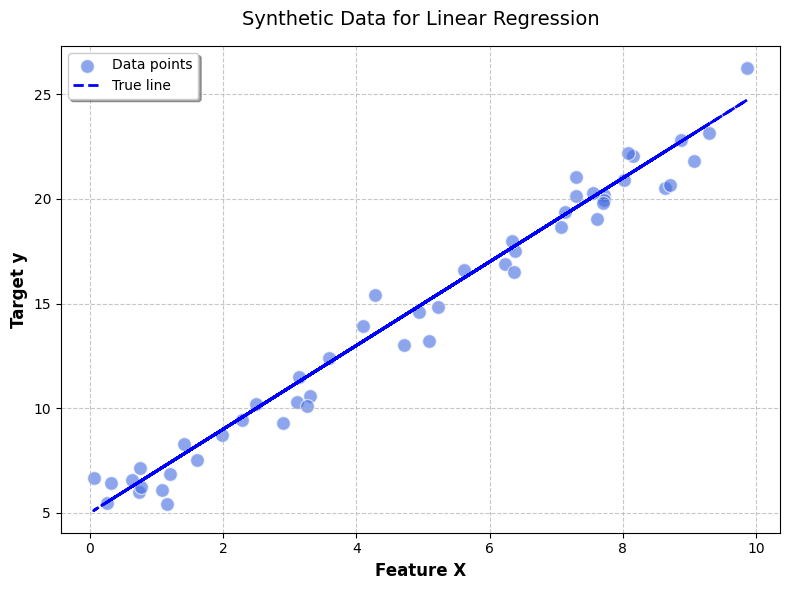

In [9]:
# Create a beautiful visualization of the synthetic data
plt.figure(figsize=(8, 6))
plt.scatter(X, y, color='royalblue', alpha=0.6, s=100, label='Data points', edgecolor='white')
plt.plot(X, 2 * X + 5, color='blue', linewidth=2, linestyle='--', label='True line')

# Customize the plot appearance
plt.xlabel('Feature X', fontsize=12, fontweight='bold')
plt.ylabel('Target y', fontsize=12, fontweight='bold') 
plt.title('Synthetic Data for Linear Regression', fontsize=14, pad=15)

# Add grid and style the legend
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(frameon=True, fancybox=True, shadow=True, fontsize=10)

plt.tight_layout()
plt.show()

Epoch [719/10000] - Loss: 2.270126 - r2: 0.874 - Weights: [1.1769899  2.54131759]:   7%|█▊                       | 719/10000 [00:01<00:17, 534.43it/s]


Convergence reached at epoch 720.
                     Final Training Report
🟢 Total Epochs Run : 720
🟢 Final MSE        : 2.269
🟢 Final R-square   : 0.874
🟢 Final Weights    : [1.1780 2.5412]
Time taken for wrapper: 1.3524 seconds


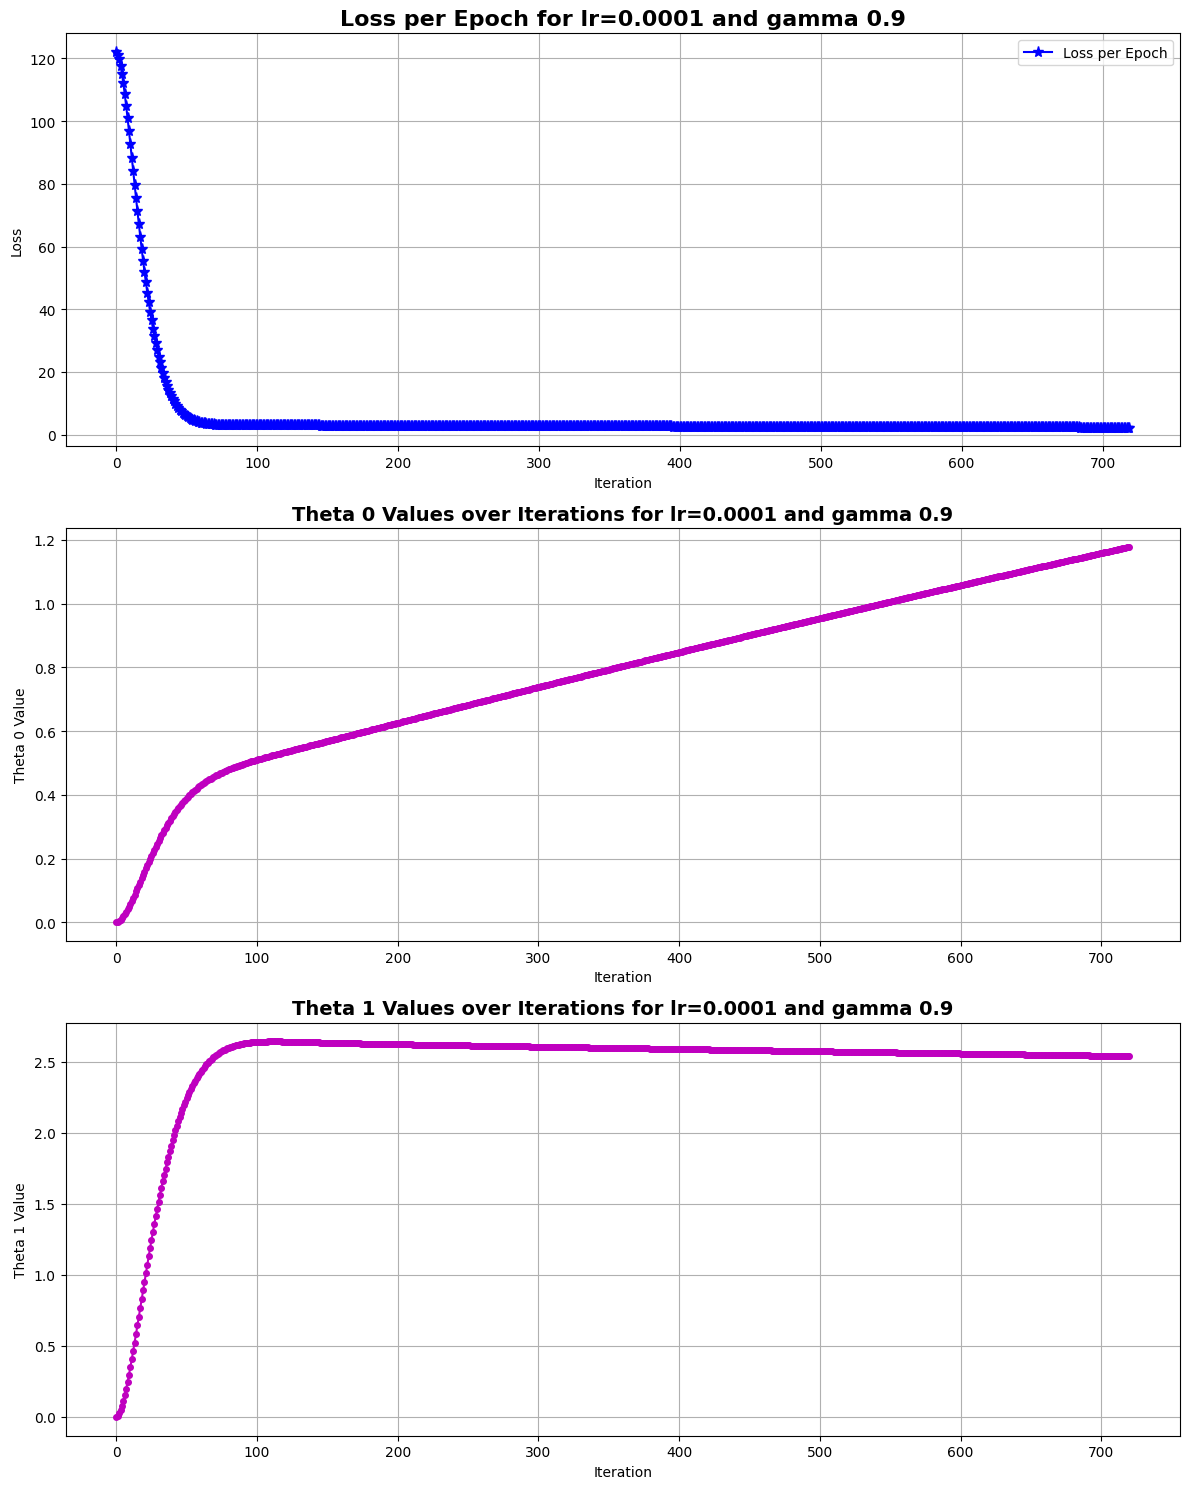

In [10]:
# Initialize hyperparameters
lr = 0.0001
g=0.9 # change gamma and try

# Run Batch GD
_, weights_history, cost_history, r2 = MomentumGD_python(X, y, learning_rate=lr, gamma=g)

# Plot results
plot_results(weights_history, cost_history, lr=f"{lr} and gamma {g}")

### Use Large Learning Rate

Epoch [896/10000] - Loss: 1.905093 - r2: 0.894 - Weights: [1.55845516 2.48360916]:   9%|██▏                      | 896/10000 [00:01<00:16, 564.49it/s]


Convergence reached at epoch 897.
                     Final Training Report
🟢 Total Epochs Run : 897
🟢 Final MSE        : 1.904
🟢 Final R-square   : 0.894
🟢 Final Weights    : [1.5596 2.4834]
Time taken for wrapper: 1.5946 seconds


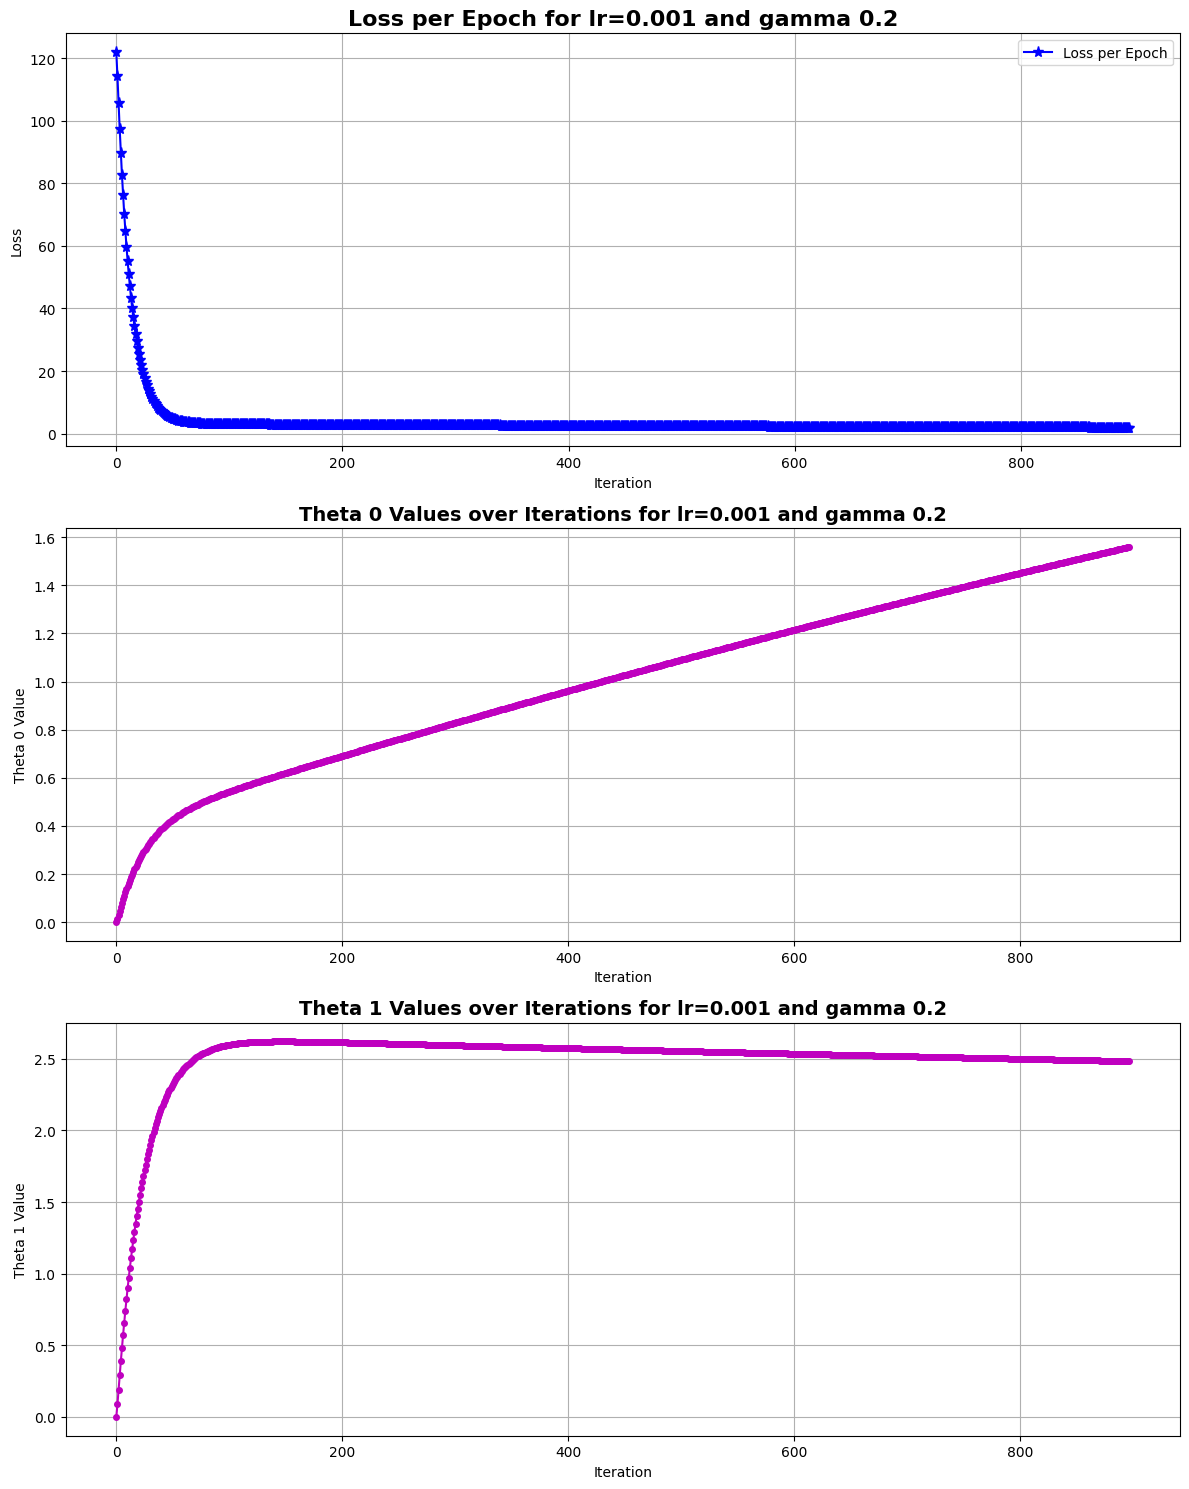

In [11]:
# Initialize hyperparameters
lr = 0.001
g = 0.2 # change gamma and try

# Run Batch GD
_, weights_history, cost_history, r2 = MomentumGD_python(X, y, learning_rate=lr, gamma=g)

# Plot results
plot_results(weights_history, cost_history, lr=f"{lr} and gamma {g}")

> Sometimes, due to the accumulation of velocity, the Momentum optimizer can take ***steps that are too large***, leading to ***overshooting the optimal weights*** and oscillating around the solution instead of converging toward it.

## 3. Momentum Batch Gradient Descent Using PyTorch
The `MomentumGD_torch` function implements the batch gradient descent algorithm using **PyTorch** to optimize the parameters (weights) of a linear regression model.

**Key Changes from the Python Code:**
1. **Data Conversion**: The input data `X` and `y` are converted to PyTorch tensors.
2. **Bias Term**: The bias term is added using `torch.cat` to create a column of ones.
3. **Gradient Calculation**: The gradient is calculated using tensor operations, leveraging PyTorch's matrix multiplication.
4. **Loss Calculation**: Losses are appended as Python floats using `loss.item()`.
5. **Weights Update**: The weights are updated in place using standard tensor operations.


### Implementing Momentum Batch Gradient Descent Using PyTorch

In [12]:
@time_decorator
@report_decorator
def MomentumGD_torch(X, y, **hyperparams):
    
    np.random.seed(42)
    torch.manual_seed(42)
    
    # Extract hyperparameters or set default values
    learning_rate = hyperparams.get('learning_rate', 0.0001)
    epochs = hyperparams.get('epochs', 10_000)
    tolerance = hyperparams.get('tolerance', 0.001)
    gamma = hyperparams.get('gamma', 0.9)
    
    X = np.insert(X, 0, 1, axis=1)      # Add bias term
    y = y.reshape(-1,1)
    m, n = X.shape                      # Number of training examples and features

    # Convert to PyTorch tensors
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)

    cost_history = []                                    # Store all losses per iteration
    weights_history = []                                 # Store all weights per iteration
    theta = torch.zeros((n, 1), dtype=torch.float32)     # Initialize theta with zeros
    velocity = torch.zeros((n, 1), dtype=torch.float32)  # Initialize velocity with zeros
    weights_history.append(theta.clone())

    # Progress bar for visual feedback
    pbar = tqdm(total=epochs, colour='green', ncols=150)
    
    for epoch in range(epochs):

        # 1. Predict output using current theta (weights)
        h_x = X_tensor @ theta

        # 2. Calculate Error for all instances
        e = (h_x - y_tensor)
        loss = torch.sum(e ** 2) / (2 * m)  # Mean Squared Error (MSE) as loss
        cost_history.append(loss.item())

        # 3. Calculate gradient
        gradient = (X_tensor.T @ e) / m

        # 4. Update velocity and weights
        velocity = gamma * velocity - learning_rate * gradient
        theta = theta + velocity  # Update weights with the velocity

        # Store weights history
        weights_history.append(theta.clone().detach().numpy())

        # Optional: Early stopping and convergence check
        if epoch > 0:
            if abs(cost_history[-1] - cost_history[-2]) < tolerance:
                print(f"Convergence reached at epoch {epoch + 1}.")
                break

        # optional Calculate r2 Score
        r2 = evaluate_model(X, y, theta.detach().numpy())
        # Print progress
        pbar.set_description(f"Epoch [{epoch+1}/{epochs}] - Loss: {loss.item():.6f} - r2: {r2:.3f} - Weights: {theta.flatten().detach().numpy()}")
        pbar.update(1)

    pbar.close()

    return epoch+1, weights_history, cost_history, r2

### Run the Model

It's essential to understand how different parameters affect the performance of the model. I encourage you to:

1. **Change the Number of Data Points**:
   - Modify the `n` parameter in the `synthetic_data` function and Observe how the amount of training data influences the model's performance and convergence speed.
   - **Example:** Try using `50, 200, or 500` data points.
   - **Note:** This will help you understand how the model's performance scales with the amount of training data.

2. **Adjust the Learning Rate**:
   - Experiment with different **learning rates** in the `batch_gd` function and Observe how the **learning rate** affects convergence.
   - **Example:** Common values to try include `0.01, 0.001, and 0.0001`.
   - **Note:** A learning rate that is too high can cause the model to oscillate before convergence, while a learning rate that is too low can slow down convergence.

3. **Adjust the Epochs Numbers**:
   - Experiment with different numbers of **epochs** in the `batch_gd` function. Observe how the number of **epochs** affects the model's performance and convergence.
   - **Example:** try `100, 500, or 1000` epochs.
   - **Note:** A larger number of epochs may lead to better convergence but may also increase training time.

### Use Small Learning Rate

Epoch [718/10000] - Loss: 2.271126 - r2: 0.874 - Weights: [1.1759996 2.5414674]:   7%|█▉                         | 718/10000 [00:01<00:24, 383.81it/s]


Convergence reached at epoch 719.
                     Final Training Report
🟢 Total Epochs Run : 720
🟢 Final MSE        : 2.270
🟢 Final R-square   : 0.874
🟢 Final Weights    : [1.1770 2.5413]
Time taken for wrapper: 1.8771 seconds


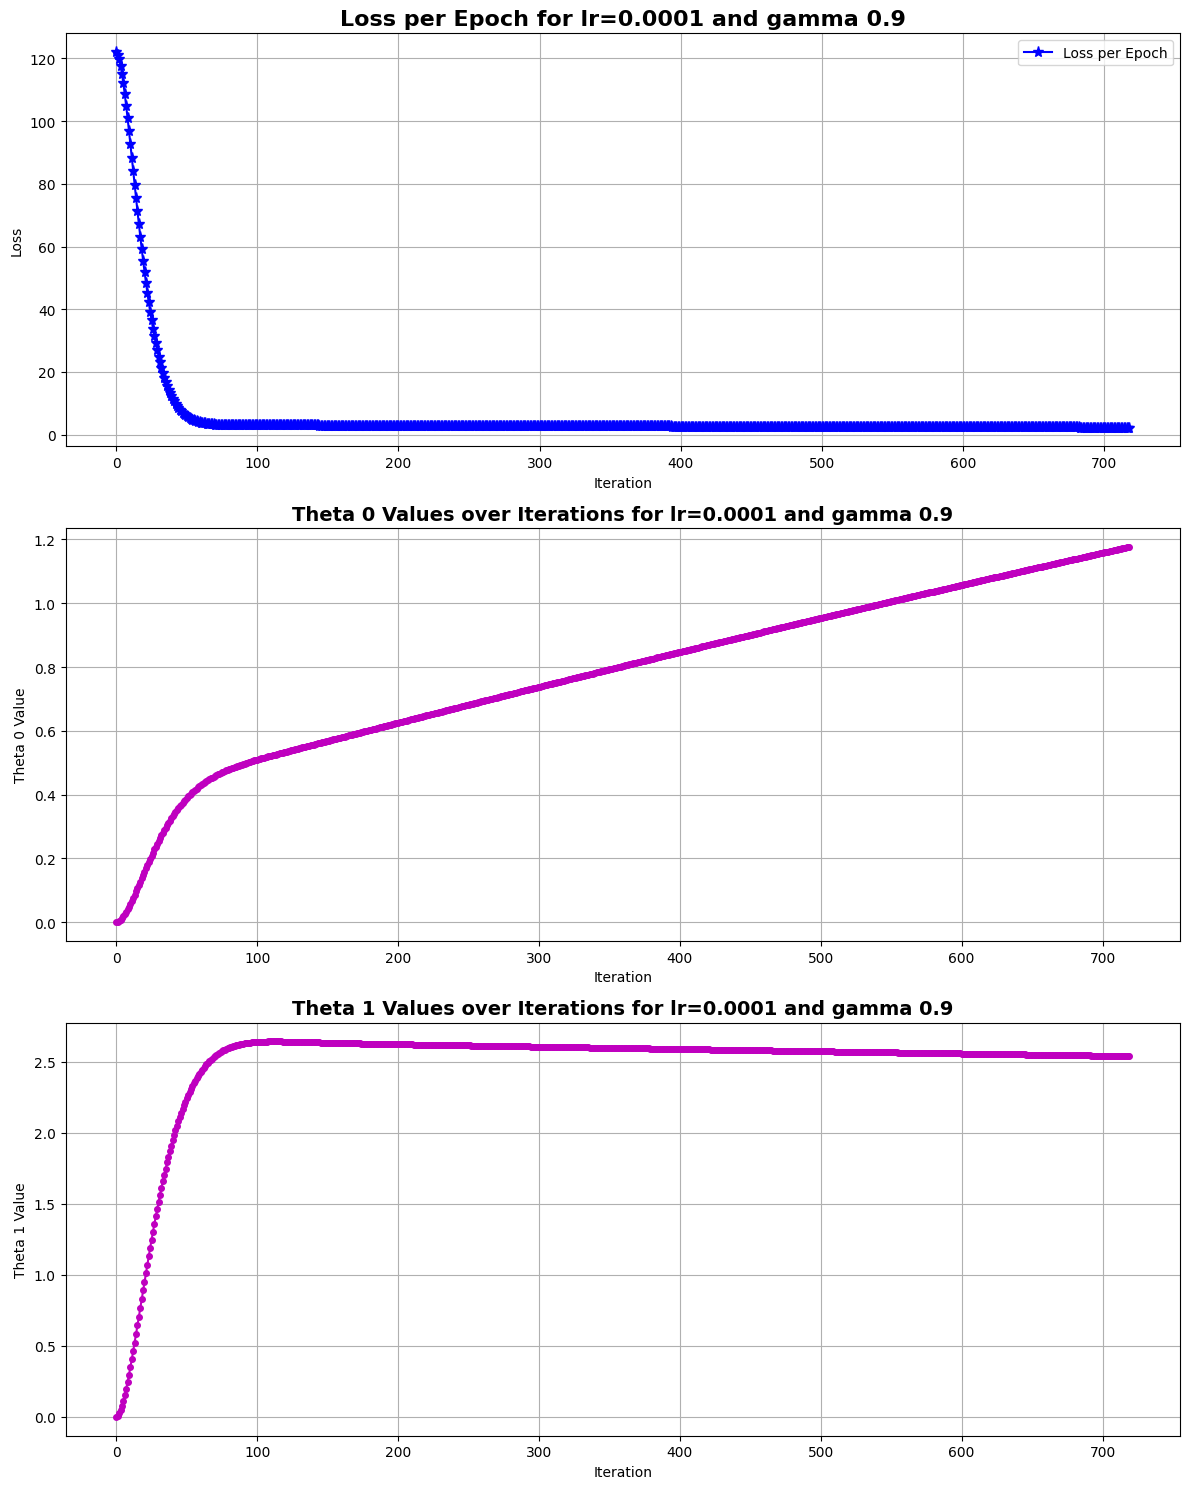

In [13]:
# Initialize hyperparameters
lr = 0.0001
g=0.9 # change gamma and try

_, weights_history, cost_history, r2 = MomentumGD_torch(X, y, learning_rate=lr, gamma=g)

# Plot results
plot_results(weights_history, cost_history, lr=f"{lr} and gamma {g}")

### Use Large Learning Rate

Epoch [82/10000] - Loss: 0.439721 - r2: 0.976 - Weights: [4.55314   2.0191896]:   1%|▏                            | 82/10000 [00:00<00:29, 335.13it/s]


Convergence reached at epoch 83.
                     Final Training Report
🟢 Total Epochs Run : 84
🟢 Final MSE        : 0.439
🟢 Final R-square   : 0.976
🟢 Final Weights    : [4.5628 2.0014]
Time taken for wrapper: 0.2517 seconds


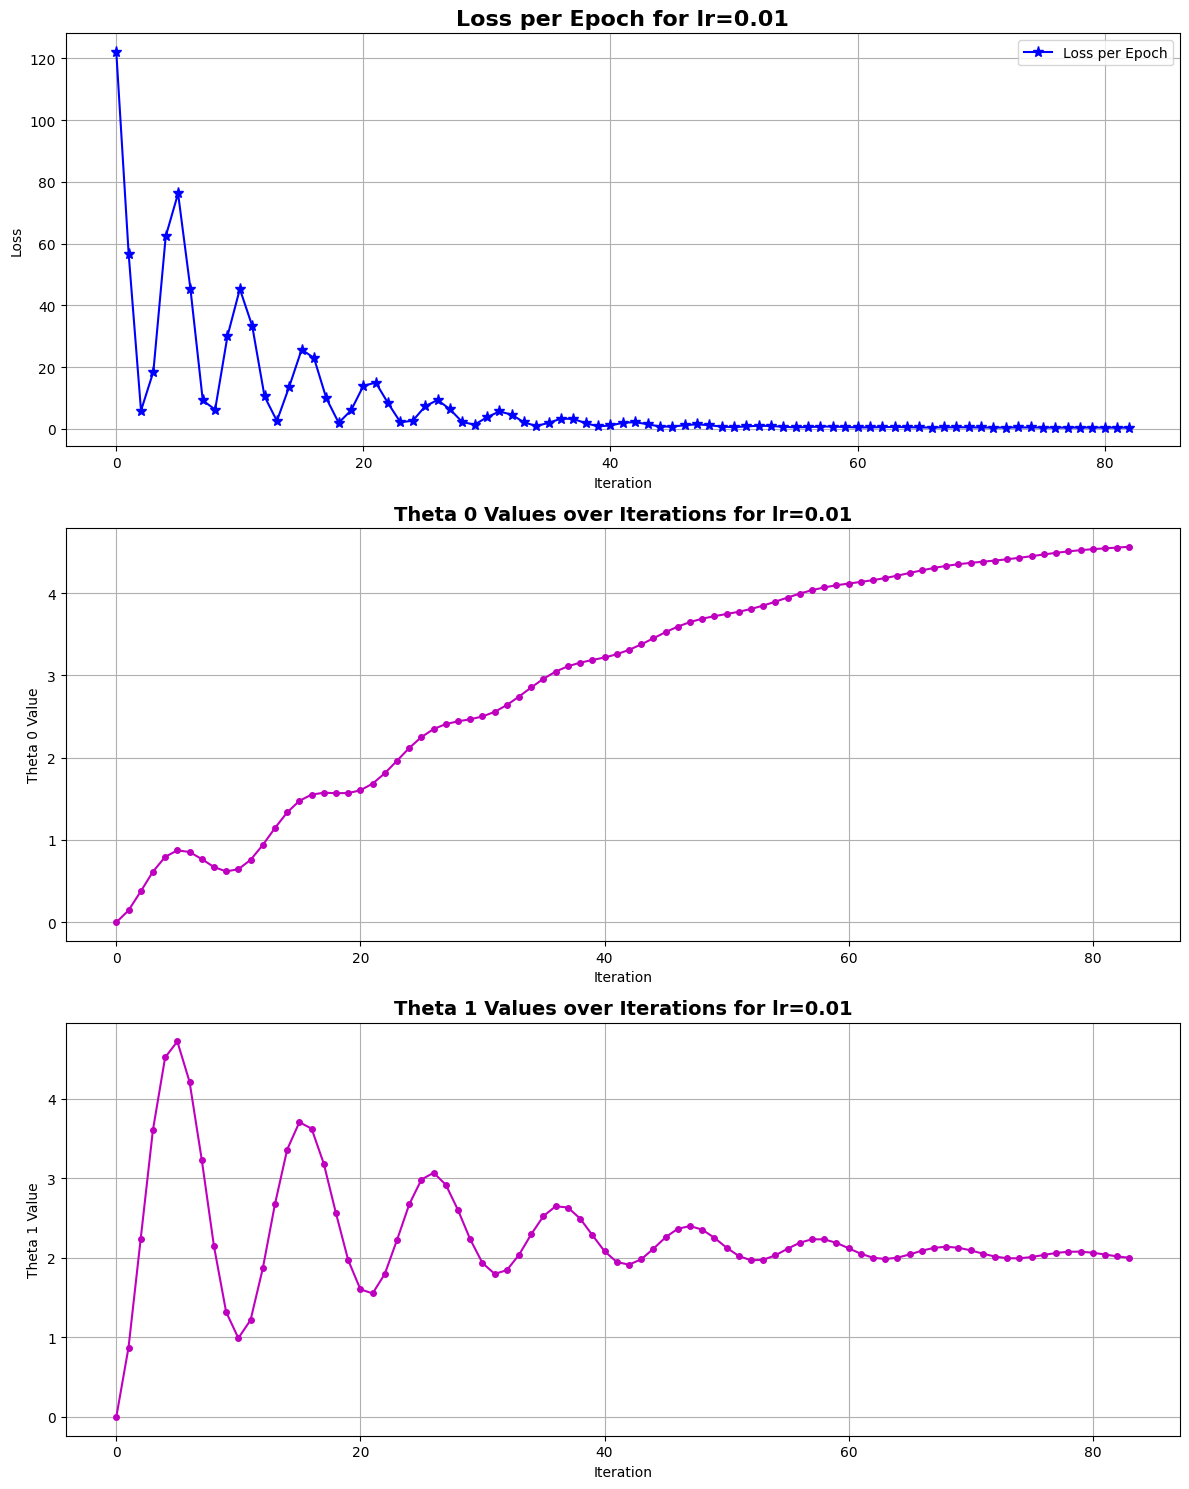

In [16]:
lr = 0.01
g = 0.9

_, weights_history, cost_history, r2 = MomentumGD_torch(X, y, learning_rate=lr, gamma=g)

# Plot results
plot_results(weights_history, cost_history, lr=lr)